In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
print(os.getcwd())
wave_path = "./bed_0b56bcfe_nohash_0.wav"
print(torchaudio.info(wave_path))

c:\DOCUMENT\Xe-blogs\source\_posts\从空气震动到梅尔频谱图
AudioMetaData(sample_rate=16000, num_frames=16000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


#### 采样过程的详细计算

f1 = 500, T = 0.002, TT = 0.01, fs = 500, N = 5
f1 = 500, T = 0.002, TT = 0.01, fs = 1000, N = 10
f1 = 500, T = 0.002, TT = 0.01, fs = 1500, N = 15
f1 = 500, T = 0.002, TT = 0.01, fs = 2000, N = 20
f1 = 500, T = 0.002, TT = 0.01, fs = 2500, N = 25
f1 = 500, T = 0.002, TT = 0.01, fs = 3000, N = 30


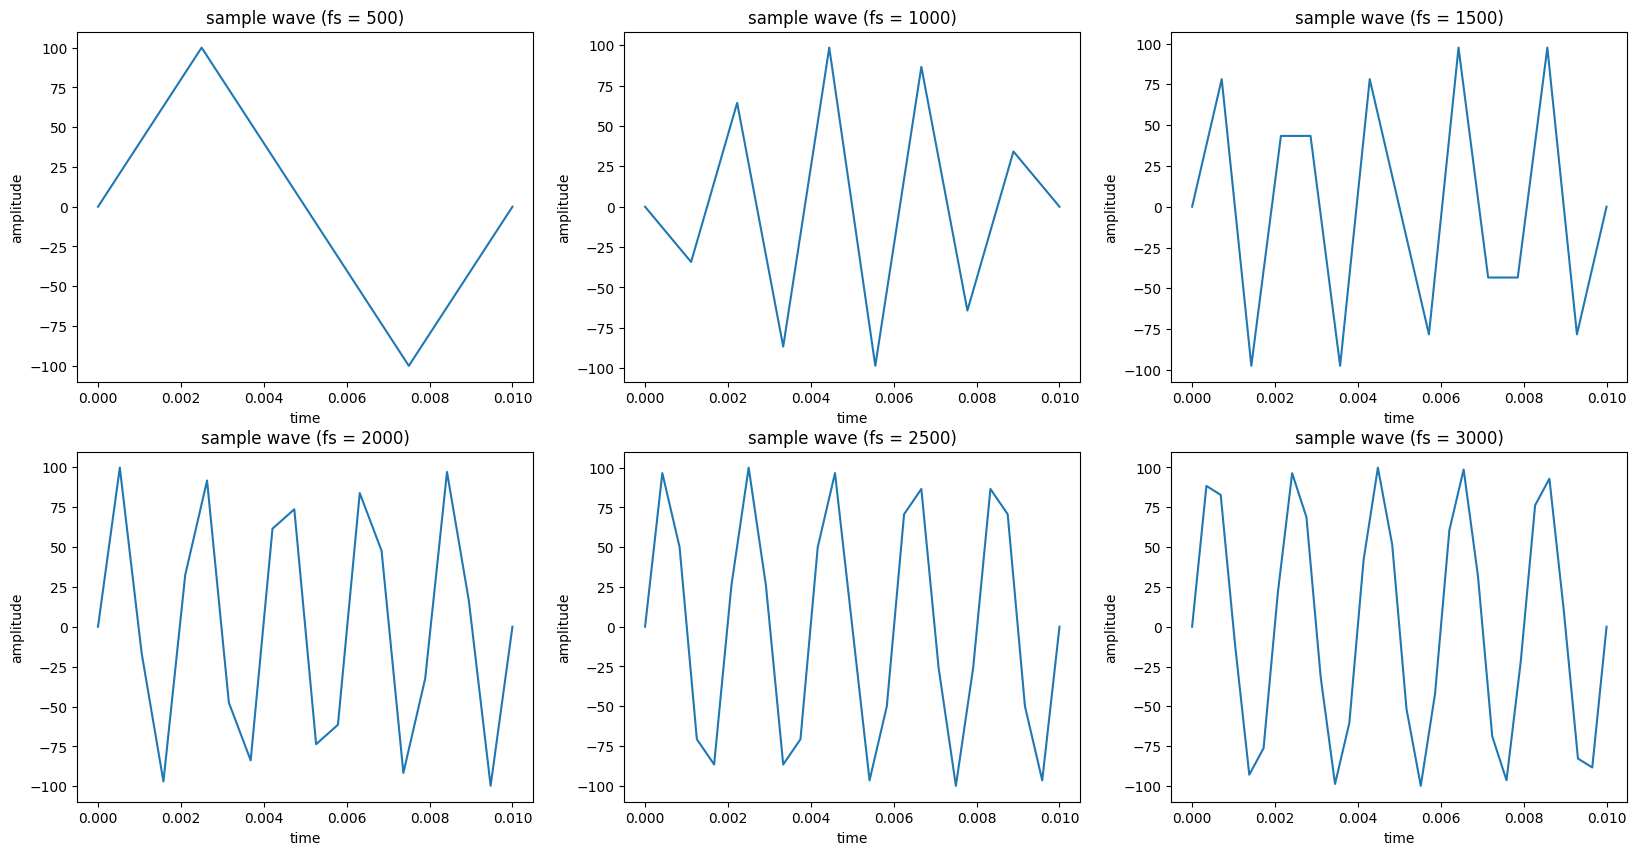

In [ ]:
# 正弦波的频率
f1 = 500
# 周期
T = 1 / f1
# 采样范围
TT = 5*T

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()):
    # 采样率
    fs = f1 * (i + 1)
    # 采样点数
    N = int(fs * TT)
    print(f"f1 = {f1}, T = {T}, TT = {TT}, fs = {fs}, N = {N}")

    x = torch.linspace(0, TT, N)
    y = 100 * torch.sin( (2*torch.pi)*f1*x)

    # 原波形
    ax.plot(x, y)
    ax.set_xlabel("time")
    ax.set_ylabel("amplitude")
    ax.set_title(f"sample wave (fs = {fs})")

max_val: 208.20628356933594


Text(0.5, 1.0, 'after FFT')

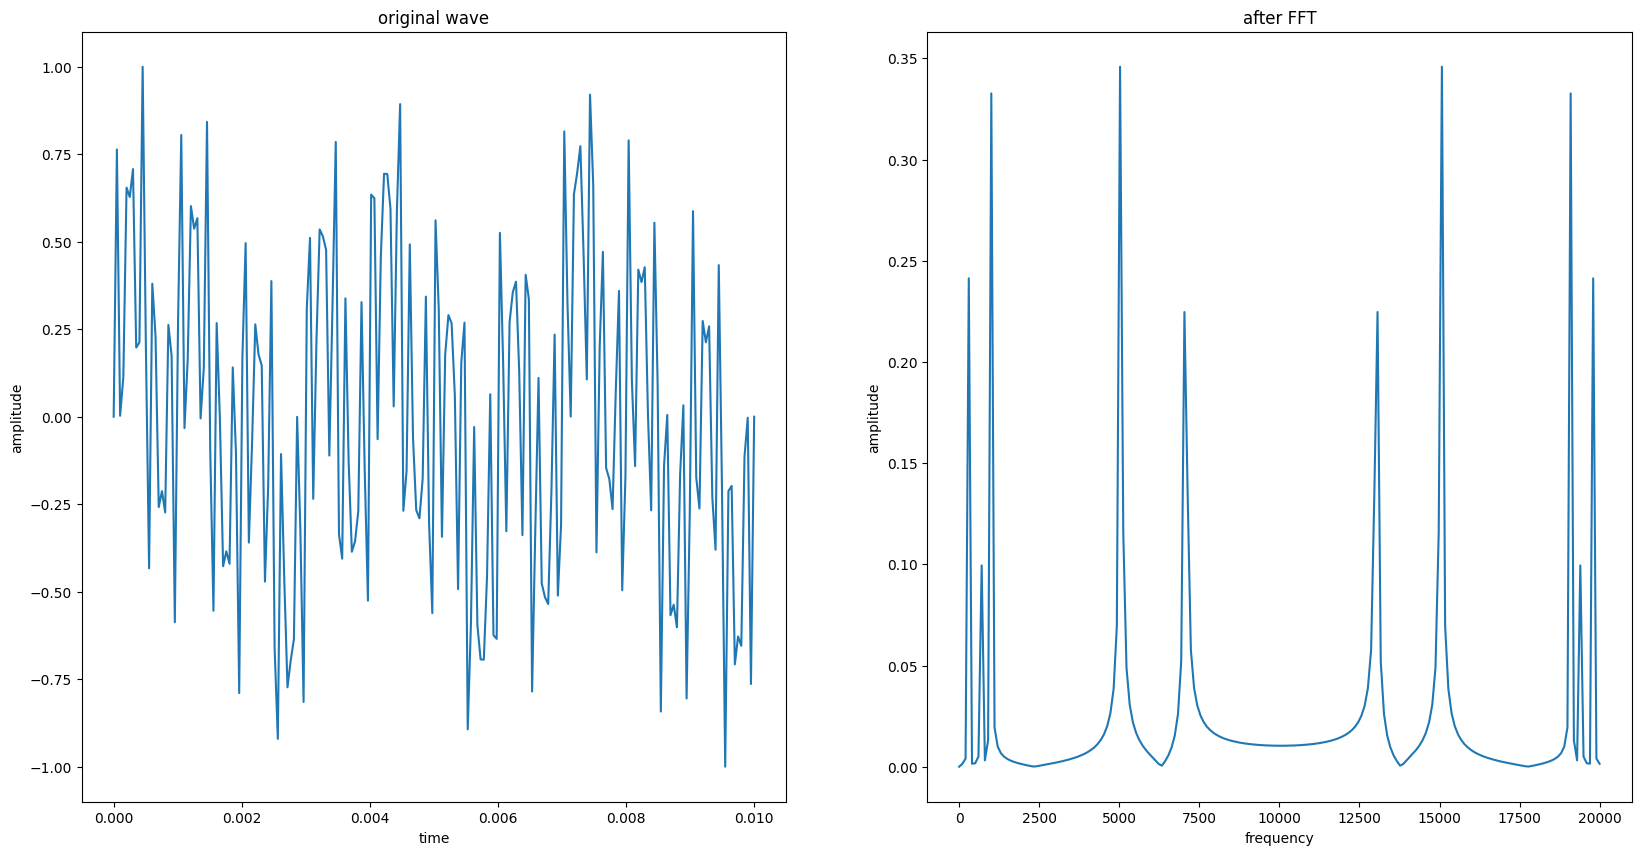

In [4]:
# 第一个正弦波
# 正弦波的频率
f1 = 1000
# 周期
T = 1 / f1
# 采样范围
TT = 10*T
# 采样率
fs = 20000

N = int(fs * TT)

# 第二个正弦波
f2 = 300

# 第三个
f3 = 700

# 第四个
f4 = 7000

# 第五个
f5 = 5000

x = torch.linspace(0, TT, N)
# 直接相加
y1 = 70 * torch.sin( (2*torch.pi)*f1*x)
y2 = 50 * torch.sin( (2*torch.pi)*f2*x)
y3 = 20 * torch.sin( (2*torch.pi)*f3*x)
y4 = 60 * torch.sin( (2*torch.pi)*f4*x)
y5 = 80 * torch.sin( (2*torch.pi)*f5*x)
# 噪声
noise = torch.randn(N) * 100

y = y1 + y2 + y3 + y4 + y5 + noise
y = y1 + y2 + y3 + y4 + y5 
# 缩放到[-1, 1]
max_val = torch.max(torch.abs(y))  # 找到绝对值最大值
if max_val > 0:
    y = y / max_val  
print(f"max_val: {max_val}")

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = [axes]
# fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# 原波形
axes[0][0].plot(x, y)
axes[0][0].set_xlabel("time")
axes[0][0].set_ylabel("amplitude")
axes[0][0].set_title("original wave")

# FFT
y_fft = torch.fft.fft(y)
y_fft = torch.abs(y_fft) / (N / 2)
x_fft = torch.linspace(0, fs, N)

axes[0][1].plot(x_fft, y_fft)
axes[0][1].set_xlabel("frequency")
axes[0][1].set_ylabel("amplitude")
axes[0][1].set_title("after FFT")

Text(0.5, 1.0, 'Keep half')

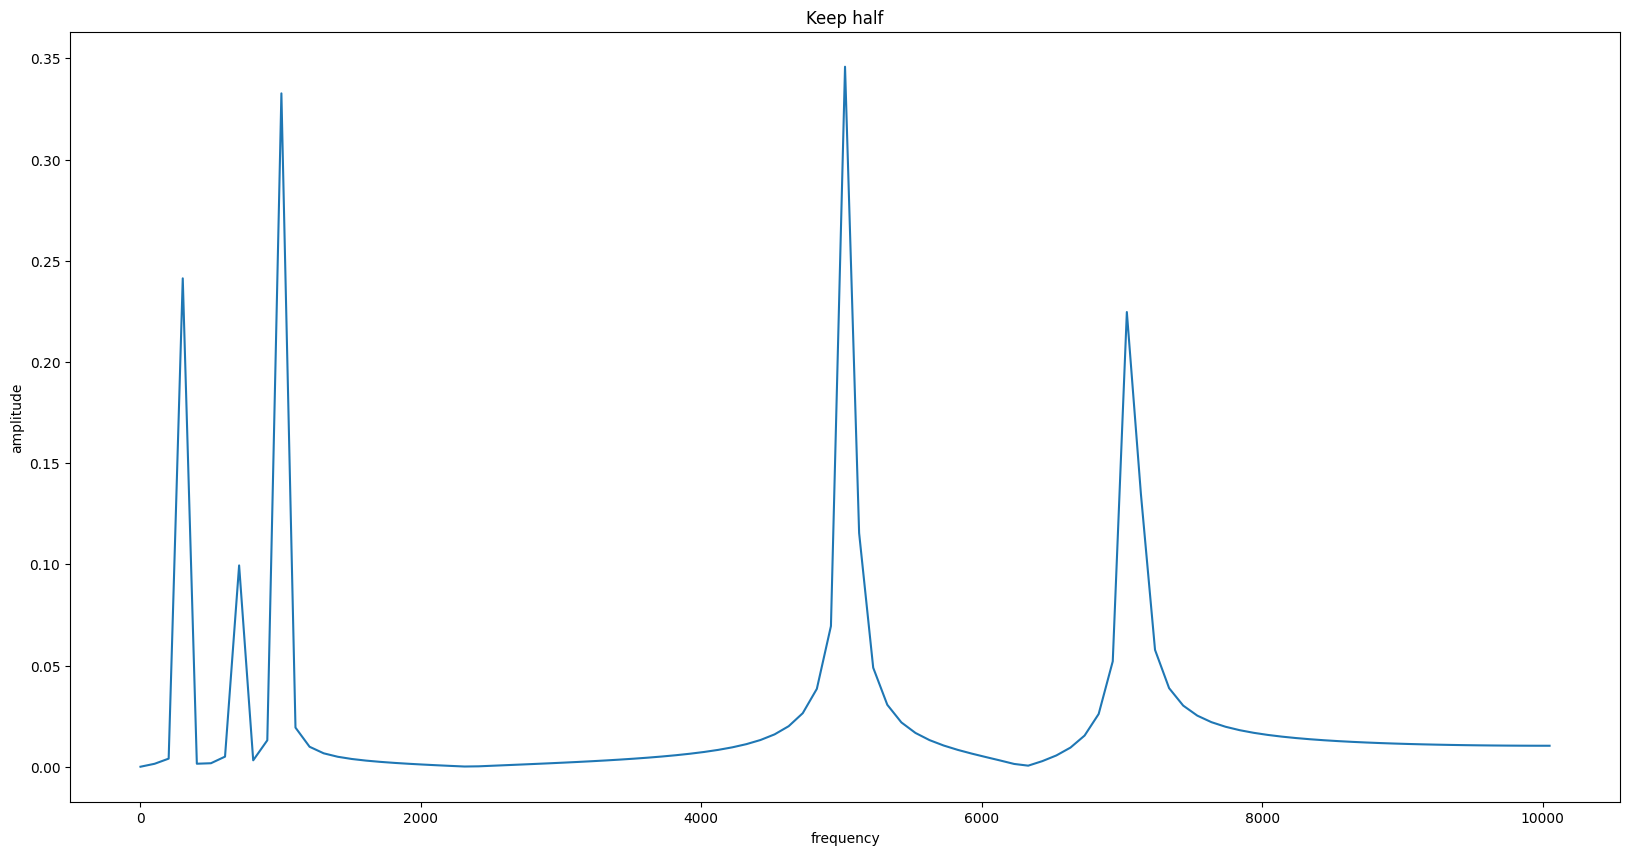

In [5]:
# 取一半
interval = fs / (N-1)
x_fft = torch.linspace(0, (N//2)*interval, N//2+1)
y_fft = y_fft[0:N//2+1]

fig, axes = plt.subplots(figsize=(20, 10))
axes.plot(x_fft, y_fft)
axes.set_xlabel("frequency")
axes.set_ylabel("amplitude")
axes.set_title("Keep half")

Text(0.5, 1.0, 'power spectrum')

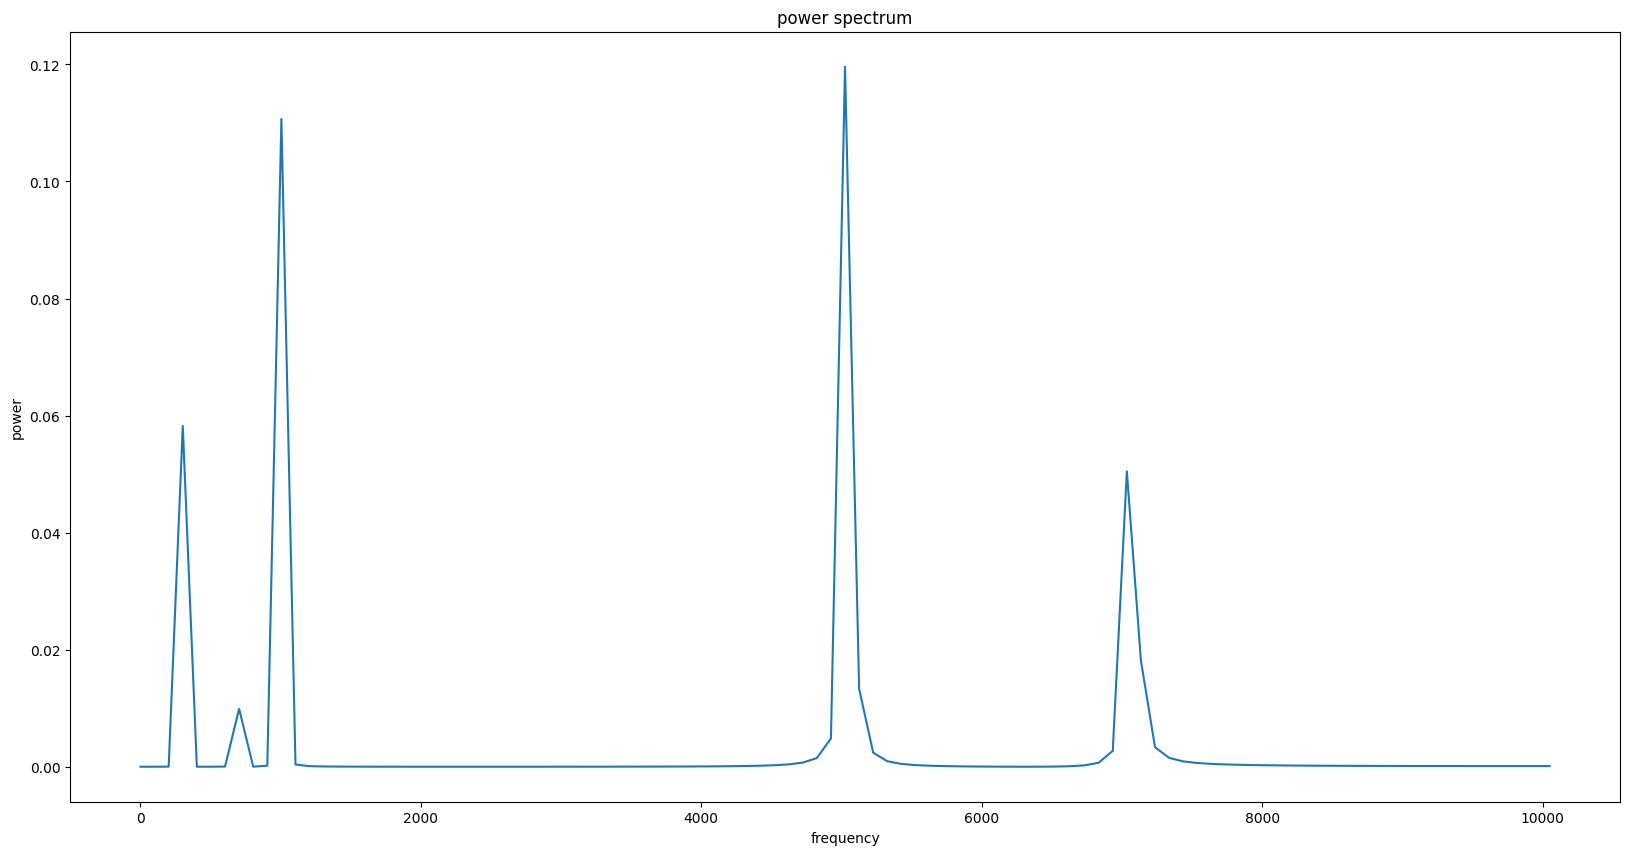

In [6]:
# 功率谱
y_pow = y_fft ** 2

fig, axes = plt.subplots(figsize=(20, 10))
axes.plot(x_fft, y_pow)
axes.set_xlabel("frequency")
axes.set_ylabel("power")
axes.set_title("power spectrum")

In [8]:
"""
输入:
    n_fft: 窗口大小
    fs: 采样率
输出:
    x: FFT 后折半保留的单位为频率的轴
    mel_fliters: (num_fliters(26), fliter_size)
"""
def get_mel_fliters(n_fft, fs):
    # 计算mel 滤波器组
    def mel_to_hz(mel):
        return 700 * (np.exp(mel / 1125) - 1)
    def hz_to_mel(hz):
        return 1125 * np.log(1 + hz / 700)
    
    # 原幅值图X 轴范围
    # 分辨率
    interval = fs / (n_fft-1)
    # 保留点数: 总的FFT 点数除以二加一
    n_fft_reserve = n_fft // 2 + 1
    # 幅值图X 轴
    x = torch.linspace(0, interval*(n_fft_reserve-1), n_fft_reserve)

    # print("x:")
    # print(x)

    # 计算mel 频率桶
    # 低于300 Hz 人耳感受不到,不需要计算这部分的能量
    hz_min = 300
    # 保留的幅值图中最大的频率
    hz_max = x[-1]
    mel_min = hz_to_mel(hz_min)
    mel_max = hz_to_mel(hz_max)
    # 26 个滤波器需要28 个点
    mel_bins = torch.linspace(mel_min, mel_max, 28)
    # 来回转换有误差, 保证转回Hz 时不超过范围
    hz_bins = torch.clamp(mel_to_hz(mel_bins), max=hz_max, min=hz_min)

    # print("hz_bins:")
    # print(hz_bins)

    # 计算原x 轴与频率桶最相近的频率索引
    hz_indexs = []
    for hz_bin in hz_bins:
        temp_abs = torch.abs(x - hz_bin)
        temp_min = temp_abs.min()
        indexs = torch.where(temp_abs == temp_min)
        hz_indexs.append(indexs[0].item())
    # print("hz_index:")
    # print(hz_indexs)
        
    # 判断频率桶是否重复, 如果重复则无法正常创造梅尔滤波器
    hz_index_set = set(hz_indexs)
    if len(hz_indexs) > len(hz_index_set):
        print("hz bin 有重复")

    # 创建mel 滤波器
    mel_fliters = torch.zeros((26, len(x)))

    for index, fliter in enumerate(mel_fliters):
        left = hz_indexs[index]
        center = hz_indexs[index + 1]
        right = hz_indexs[index + 2]

        # 线性上升部分
        for i in range(left, center):
            fliter[i] = (i - left) / (center - left)

        # 线性下降部分
        for i in range(center, right):
            fliter[i] = (right - i) / (right - center)
        
    return x, mel_fliters


C:\Users\Xe-131\AppData\Local\Temp\ipykernel_240\1317859244.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1125 * np.log(1 + hz / 700)
C:\Users\Xe-131\AppData\Local\Temp\ipykernel_240\1317859244.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 700 * (np.exp(mel / 1125) - 1)


(0.0, 0.15)

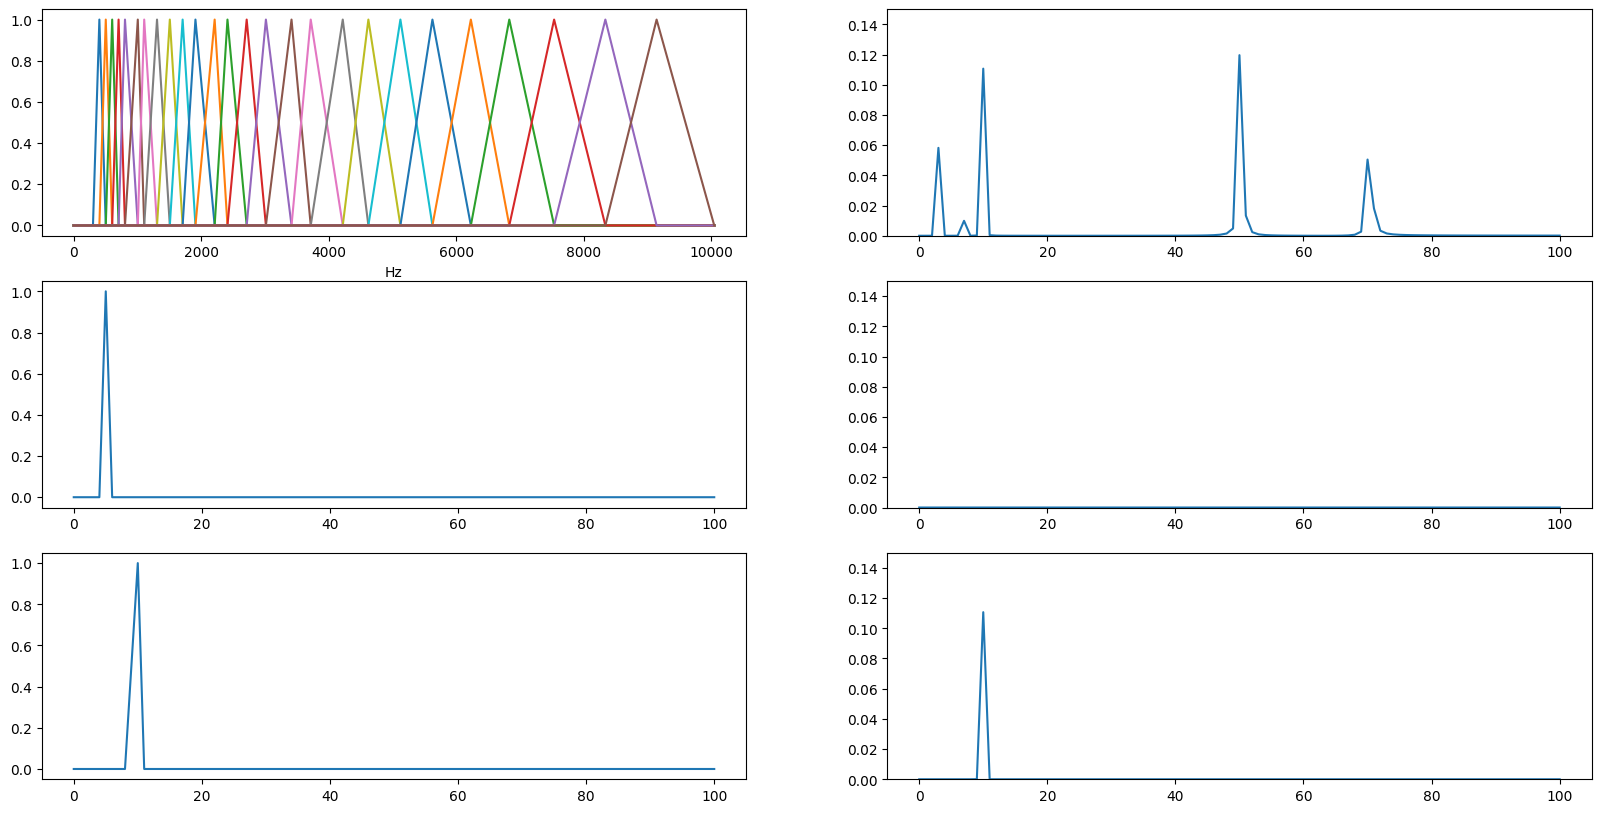

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
ax = axes.flatten()


# 26 个梅尔滤波器叠加
x, mel_fliters = get_mel_fliters(N, fs)
for fliter in mel_fliters:
    ax[0].plot(x, fliter)
ax[0].set_xlabel("Hz")

# 原波形
ax[1].plot(y_pow)
ax[1].set_ylim(0, 0.15) 

# 第2个滤波器
ax[2].plot(mel_fliters[1])

# 被第2 个滤波器滤波后的原波形
ax[3].plot(mel_fliters[1] * y_pow)
ax[3].set_ylim(0, 0.15) 

# 第6个滤波器
ax[4].plot(mel_fliters[5])

# 被第6 个滤波器滤波后的原波形
ax[5].plot(mel_fliters[5] * y_pow)
ax[5].set_ylim(0, 0.15) 

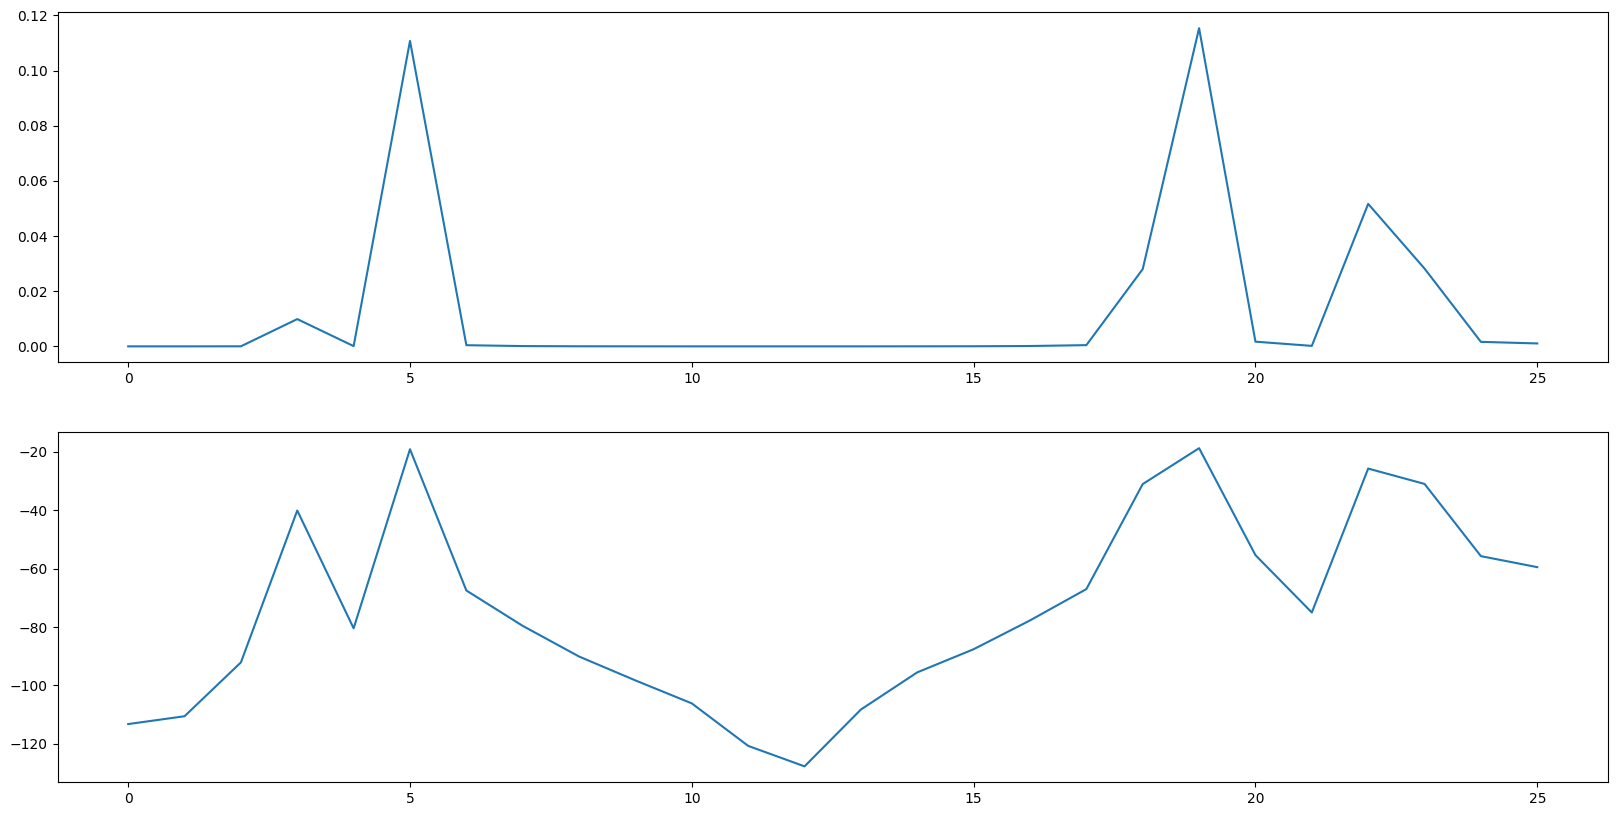

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# 得到梅尔频谱图
mel_data = []
for mel_fliter in mel_fliters:
    mel_data.append((mel_fliter * y_pow).sum() )
axes[0].plot(mel_data)

# 将能量对数化, 转化成分贝
mel_data = torch.tensor(mel_data)
mel_data = 20*torch.log10(mel_data + 1e-10)
axes[1].plot(mel_data)

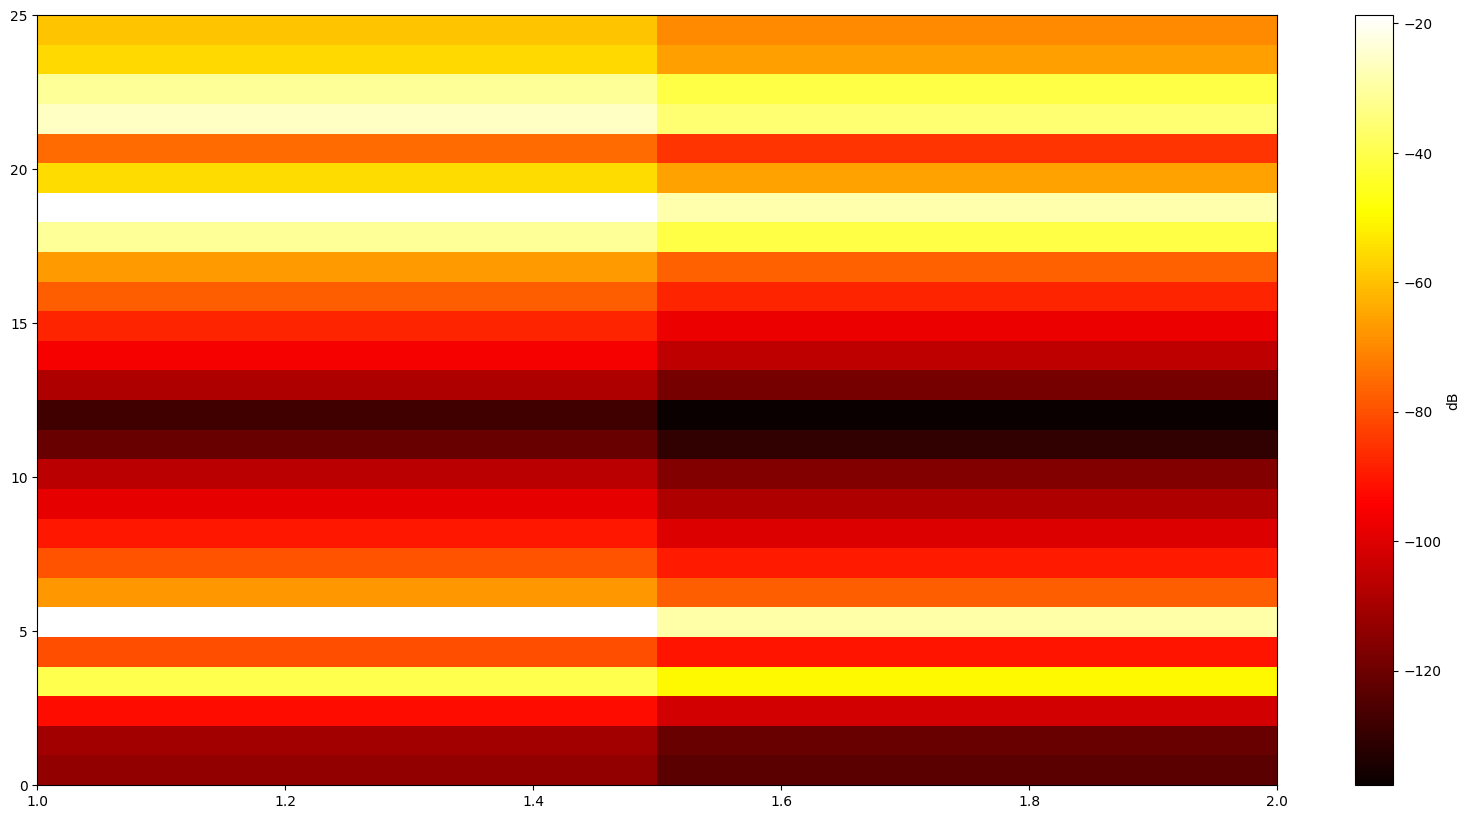

In [14]:
fig, axes = plt.subplots(figsize=(20, 10))
mel_data_double = torch.stack((mel_data, mel_data-10))

im = axes.imshow(mel_data_double.T, aspect="auto", origin="lower", cmap="hot", extent=[1, 2, 0, 25])
cbar = fig.colorbar(im, ax=axes)
cbar.set_label("dB")

In [206]:
def wave_to_spectrogram(wave, fs, n_fft, hop_length):
    # 分窗
    spectrogram = []
    for i in range(0, len(wave), hop_length):
        if (i+n_fft) > len(wave):
            print("分窗: 最后的数据不够一个窗口")
            break
        spectrogram.append(wave[i:i+n_fft])
    spectrogram = torch.stack(spectrogram, dim=0)
    # 加窗
    hann_win = torch.hann_window(n_fft).unsqueeze(0)
    spectrogram = spectrogram * hann_win
    
    # print(f"after window max: {spectrogram.max()}")
    # print(f"after window min: {spectrogram.min()}")
    # print(spectrogram.shape)

    # 傅里叶变换 ---> 幅值图
    temp_spectrogram = []
    for window in spectrogram:
        window_after_fft = torch.fft.fft(window)
        # 振幅
        window_after_fft = torch.abs(window_after_fft)
        # 平摊振幅
        window_after_fft = window_after_fft / (n_fft/2)
        # 保留前一半
        temp_spectrogram.append(window_after_fft[0:(n_fft//2)])
    spectrogram = torch.stack(temp_spectrogram)

    # print(f"after FFT max: {spectrogram.max()}")
    # print(f"after FFT min: {spectrogram.min()}")
    # print(spectrogram.shape)

    fig, axes = plt.subplots(figsize=(5, 5))
    im = axes.imshow(spectrogram.T, aspect="auto", origin="lower", cmap="hot", extent=[1, spectrogram.shape[0], 0, 8000])
    axes.set_xlabel("frame")
    axes.set_ylabel("fregency (Hz)")
    axes.set_title("amplitude")
    # 添加颜色条
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_label("amplitude")


    # 幅值图 ---> 功率谱
    spectrogram = spectrogram ** 2

    # print(f"after pow max: {spectrogram.max()}")
    # print(f"after pow min: {spectrogram.min()}")
    # print(spectrogram.shape)
    
    fig, axes = plt.subplots(figsize=(5, 5))
    im = axes.imshow(spectrogram.T, aspect="auto", origin="lower", cmap="hot", extent=[1, spectrogram.shape[0], 0, 8000])
    # 添加颜色条
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_label("amplitude * amplitude")
    # 设置轴标签
    axes.set_xlabel("Frame")
    axes.set_ylabel("Frequency (Hz)")
    axes.set_title("Power")



    # 对每个窗口进行mel 滤波, 得到26 个能量
    x, mel_fliters = get_mel_fliters(n_fft, fs)
    powers = []
    for window in spectrogram:
        power = []
        for mel_fliter in mel_fliters:
            pow = (mel_fliter * window).sum()
            power.append(pow)
        powers.append(power)
    spectrogram = torch.tensor(powers)


    fig, axes = plt.subplots(figsize=(5, 5))
    im = axes.imshow(spectrogram.T, aspect="auto", origin="lower", cmap="hot", extent=[1, spectrogram.shape[0], 1, spectrogram.shape[1]])
    # 添加颜色条
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_label("Power")
    # 设置轴标签
    axes.set_xlabel("Frame")
    axes.set_ylabel("fliter index")
    axes.set_title("mel Power")

    print(f"after pow max: {spectrogram.max()}")
    print(f"after pow min: {spectrogram.min()}")
    print(spectrogram.shape)
    

    # 对数化
    spectrogram = 20 * torch.log10(spectrogram + 1e-10)

    print(f"after pow max: {spectrogram.max()}")
    print(f"after pow min: {spectrogram.min()}")
    print(spectrogram.shape)

    fig, axes = plt.subplots(figsize=(5, 5))
    im = axes.imshow(spectrogram.T, aspect="auto", origin="lower", cmap="hot", extent=[1, spectrogram.shape[0], 1, spectrogram.shape[1]])
    # 添加颜色条
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_label("Power")
    # 设置轴标签
    axes.set_xlabel("Frame")
    axes.set_ylabel("fliter index")
    axes.set_title("mel Power")



分窗: 最后的数据不够一个窗口
after pow max: 0.07697879523038864
after pow min: 2.018553380001009e-11
torch.Size([98, 26])
after pow max: -22.2725772857666
after pow min: -198.4029541015625
torch.Size([98, 26])


C:\Users\Xe-131\AppData\Local\Temp\ipykernel_20156\2329240645.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1125 * np.log(1 + hz / 700)
C:\Users\Xe-131\AppData\Local\Temp\ipykernel_20156\2329240645.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 700 * (np.exp(mel / 1125) - 1)


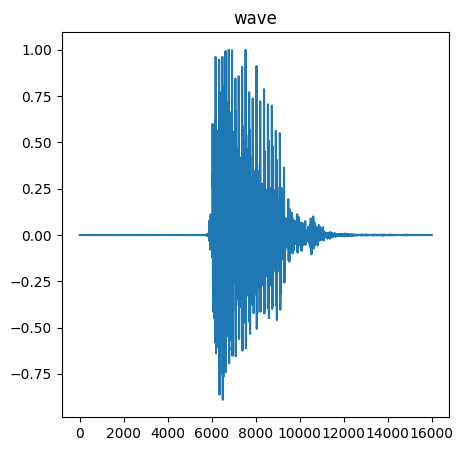

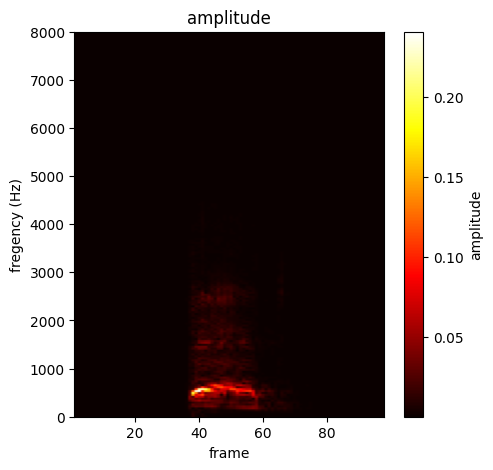

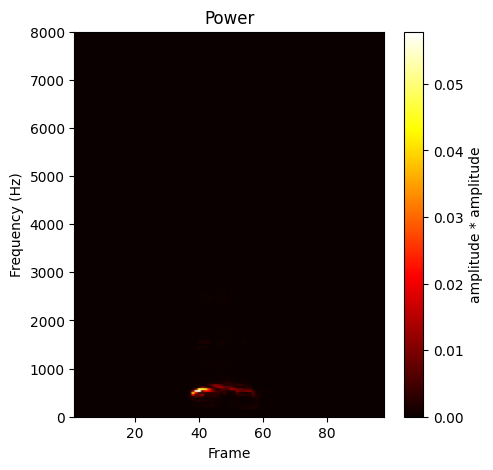

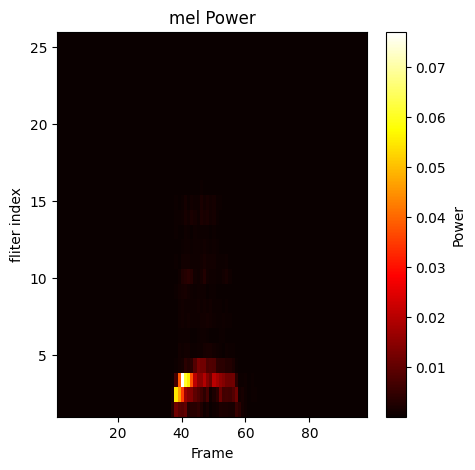

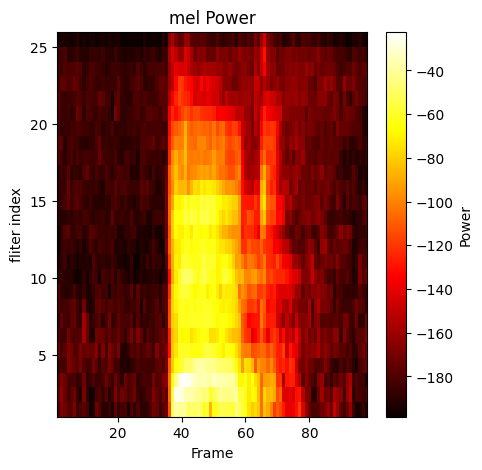

In [207]:
# 读取音频
wave_path = "./bed_0b56bcfe_nohash_0.wav"
wave = torchaudio.load(wave_path)

# 归一化到[-1, 1]
max_val = torch.max(torch.abs(wave[0][0]))  # 找到绝对值最大值
if max_val > 0:
    wave = wave[0][0] / max_val  

fig, axes = plt.subplots(figsize=(5, 5))
axes.plot(wave)
axes.set_title("wave")

# 1s = 25ms * 40
# 窗口大小: 25ms * 16000 = 400
# 步长: 10ms * 16000 = 160
n_fft = 400
hop_length = 160
fs = 16000
wave_to_spectrogram(wave, fs, n_fft, hop_length)


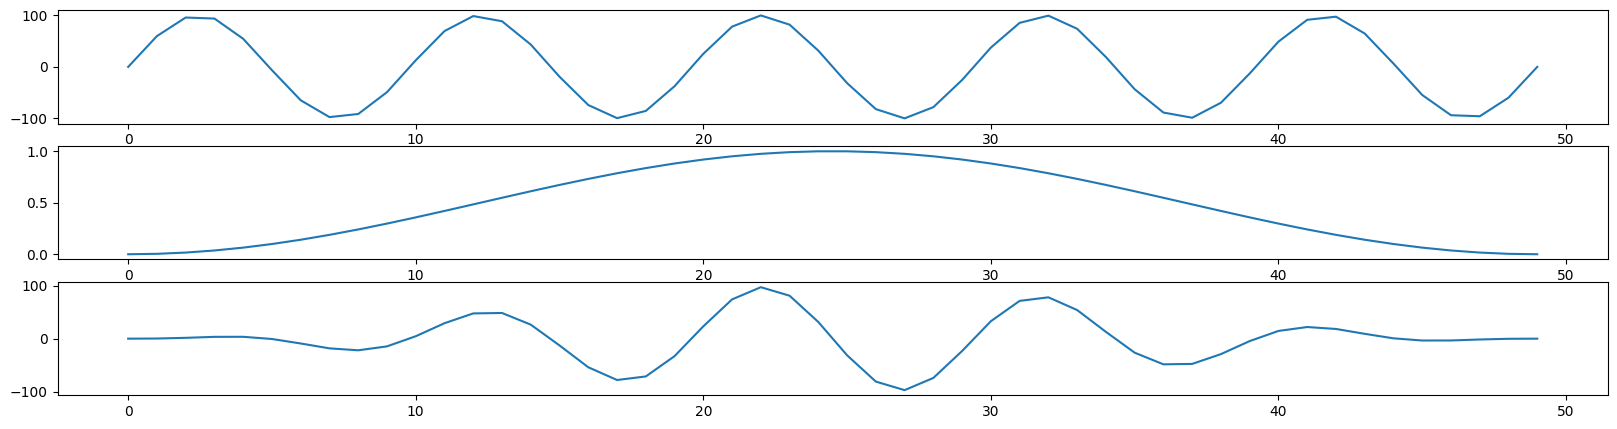

In [279]:
# 正弦波的频率
f1 = 500
# 周期
T = 1 / f1
# 采样范围
TT = 5*T
# 采样率
fs = f1 * 10
# 采样点数
N = int(fs * TT)

x = torch.linspace(0, TT, N)
y = 100 * torch.sin( (2*torch.pi)*f1*x)

fig, axes = plt.subplots(3, 1, figsize=(20, 5))

# 原波形
axes[0].plot(y)

# 窗函数
hann_window = torch.windows.hann(len(y))
axes[1].plot(hann_window)

# 相乘（加窗）
axes[2].plot(hann_window * y)